##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 画像分類のためのフェデレーテッドラーニング

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.orgで表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/federated/tutorials/federated_learning_for_image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/federated/tutorials/federated_learning_for_image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示{</a></td>
</table>

**注**: この Colab は、`tensorflow_federated` pip パッケージの[最新リリースバージョン](https://github.com/tensorflow/federated#compatibility)で動作することが確認されていますが、Tensorflow Federated プロジェクトはまだプレリリース開発中なので<code>master</code>では動作しない可能性があります。

このチュートリアルでは、クラシックな MNIST トレーニングの例を使用して、TFF の Federated Learning (FL) API レイヤー、`tff.learning`を紹介します。これは TensorFlow に実装されたユーザー指定モデルに対するフェデレーテッドトレーニングなどの一般的なタイプのフェデレーテッドラーニングタスクを実行するために使用できる、より高レベルの一連のインターフェースです。

このチュートリアルと Federated Learning API は、主に TFF に独自の TensorFlow モデルをプラグインし、後者を主にブラックボックスとして扱うユーザーを対象としています。TFF の詳細と独自のフェデレーテッドラーニングアルゴリズムの実装方法については、FC Core API-[カスタムフェデレーテッドアルゴリズムパート 1 ](custom_federated_algorithms_1.ipynb)および[パート 2 ](custom_federated_algorithms_2.ipynb)のチュートリアルを参照してください。

`tff.learning`の詳細については、[「テキスト生成のためのフェデレーテッドラーニング」](federated_learning_for_text_generation.ipynb)チュートリアルに進んでください。このチュートリアルでは、反復モデルだけでなく、事前学習済みのシリアル化された Keras モデルを読み込み、Keras を使用した評価とフェデレーテッドラーニングを使った微調整のためのデモも行います。

## 始める前に

始める前に、次のコードを実行し、環境が正しくセットアップされていることを確認してください。挨拶文が表示されない場合は、[インストール](../install.md)ガイドで手順を確認してください。 

In [ ]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow_federated

%load_ext tensorboard

In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

## 入力データを準備する

まず、データから始めましょう。フェデレーテッドラーニングには、フェデレーテッドデータセット、つまり複数のユーザーからのデータのコレクションが必要です。フェデレーテッドデータは通常、非 [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) であり、固有の一連の課題があります。

TFF リポジトリには、実験を容易にするためにいくつかのデータセットがシードされています。データセットには、[Leaf](https://github.com/TalwalkarLab/leaf) を使用して再処理された[元の NIST データセット](https://www.nist.gov/srd/nist-special-database-19)のバージョンを含む MNIST のフェデレーテッドバージョンが含まれているので、データは数字の元のライターによってキー設定されています。各ライターには独自のスタイルがあるため、このデータセットは、フェデレーテッドデータセットに期待される非 i.i.d の動作を示します。

以下の手順に従って読み込みます。

In [ ]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

`load_data()`によって返されるデータセットは、`tff.simulation.ClientData`のインスタンスです。これは、ユーザーのセットを列挙したり、特定のユーザーのデータを表す`tf.data.Dataset`を構築したり、個々の要素の構造を照会したりするためのインターフェースです。以下のように、このインターフェースを使用してデータセットのコンテンツを探索します。このインターフェースではクライアント ID を反復処理できますが、これはシミュレーションデータの機能であることに注意してください。以下で説明しますが、クライアント ID はフェデレーテッドラーニングフレームワークでは使用されません。クライアント ID の唯一の目的は、シミュレーション用にデータのサブセットを選択できるようにすることです。

In [ ]:
len(emnist_train.client_ids)

3383

In [ ]:
emnist_train.element_type_structure

OrderedDict([('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None)), ('label', TensorSpec(shape=(), dtype=tf.int32, name=None))])

In [ ]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

1

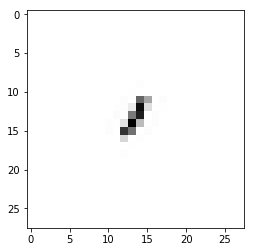

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

### フェデレーテッドデータの異質性の調査

フェデレーテッドデータは通常、非 [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) であり、通常、ユーザーの使用パターンに応じてデータの分布が異なります。一部のクライアントではデバイスでのトレーニング例が少なく、ローカルでデータ不足になっているかもしれませんが、その他のクライアントは十分なトレーニング例を持っている場合があります。利用可能な EMNIST データを使用して、 フェデレーテッドシステムに典型的なデータの異質性の概念を見てみましょう。ここで注意すべき重要な点は、シミュレーション環境ではすべてのデータをローカルで使用できるのでクライアントのデータの深い分析を実行することができるということです。実際の本番環境のフェデレーテッド環境では、1 つのクライアントのデータを検査することはできません。

まず、1 つのクライアントのデータのサンプリングを取得して、1 つのシミュレートされたデバイスでの例を見てみましょう。ここで使用しているデータセットは一意のライターによってキー設定されているため、1 つのクライアントのデータは、0〜9 の数字のサンプルに対する 1 人の手書きを表し、1 人のユーザーの一意の「使用パターン」をシミュレートします。

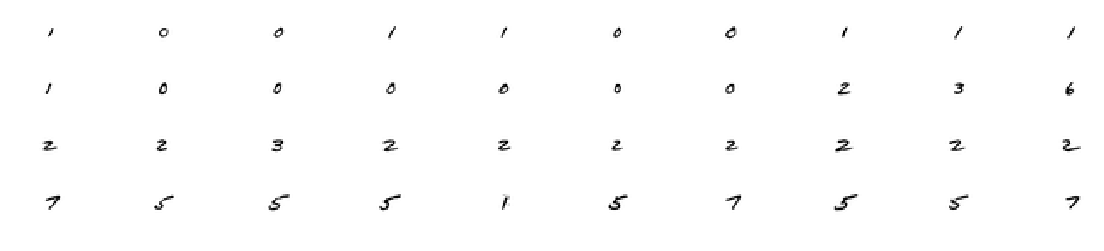

In [ ]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

次に、各クライアントの各 MNIST 数字ラベルの例の数を可視化します。フェデレーテッド環境では、各クライアントのサンプルの数は、ユーザーの動作により大幅に異なる場合があります。

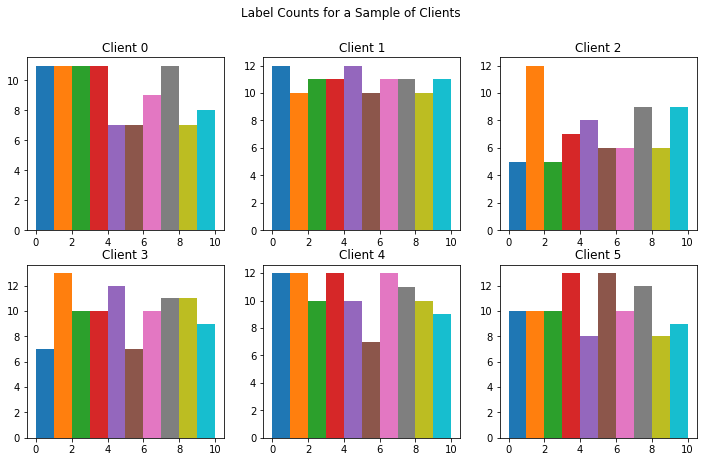

In [ ]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

次に、各 MNIST ラベルのクライアントごとの平均画像を可視化します。このコードは、1つのラベルに対するユーザーのすべての例の各ピクセル値の平均を生成します。手書きスタイルは一人一人の独特なので、あるクライアントの数字の平均画像は、別のクライアントの同じ数字の平均画像とは異なることが分かります。各ローカルラウンドでは、そのユーザー自身の一意のデータから学習されるため、ローカルトレーニングラウンドごとにそれぞれのクライアントで異なる方向にモデルがナッジされる様子を考察できます。チュートリアルの後半では、すべてのクライアントからモデルへの各更新を取得し、それらをクライアントの独自の各データから学習した新しいグローバルモデルに集約する方法を見ていきます。

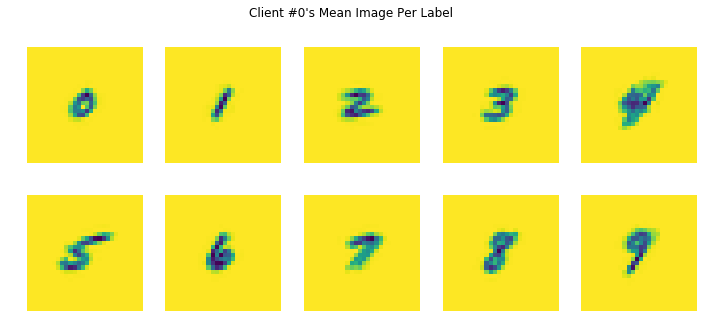

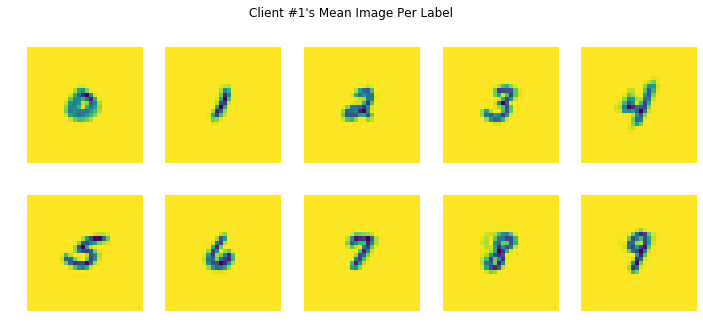

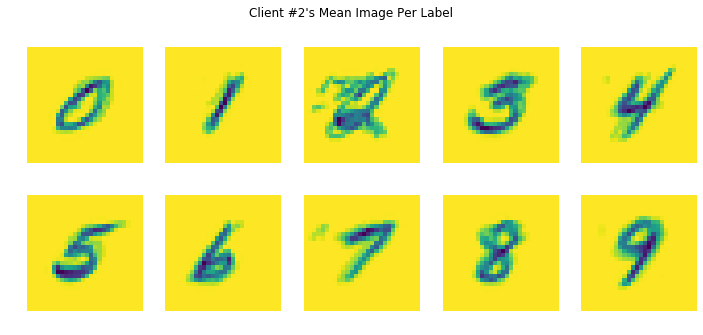

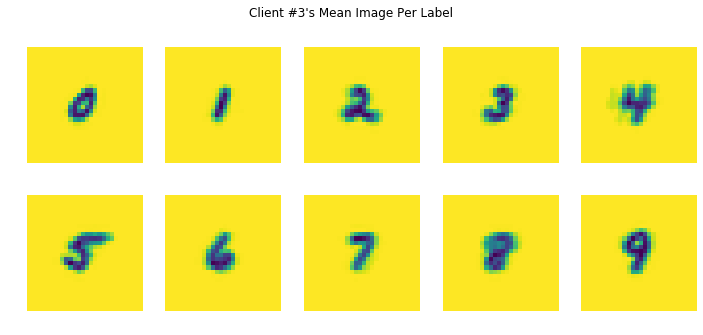

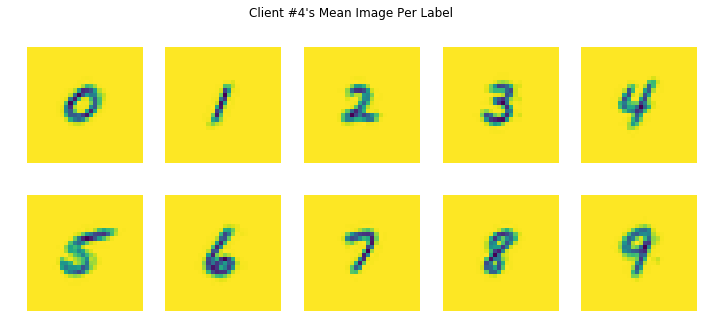

In [ ]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

ユーザーデータはノイズが多く、ラベルが付けにおける信頼性が低い可能性があります。たとえば、上のクライアント＃2 のデータを見ると、ラベル 2 について、ラベルが間違って付けられた例があったためノイズの多い平均画像が作成された可能性があることがわかります。

### 入力データの処理

データはすでに`tf.data.Dataset`であるため、データセット変換を使用して前処理を実行できます。ここでは、Keras で使用するために`28x28`の画像を`784`要素の配列にフラット化し、個々の例をシャッフルし、バッチに編成し、機能の名前を`pixels`と`label`から`x`と`y`に変更します。また、データセットに`repeat`を使用して、数エポック実行します。

In [ ]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER=10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

機能していることを確認します。

In [ ]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)), ('y', array([[2],
       [1],
       [2],
       [3],
       [6],
       [0],
       [1],
       [4],
       [1],
       [0],
       [6],
       [9],
       [9],
       [3],
       [6],
       [1],
       [4],
       [8],
       [0],
       [2]], dtype=int32))])

フェデレーテッドデータセットを構築するためのほぼすべてのビルディングブロックが整いました。

シミュレーションでフェデレーテッドデータを TFF にフィードする方法の 1 つとして Python リストを使用できます。リストの各要素は、リストまたは`tf.data.Dataset`として個々のユーザーのデータを保持します。tf.data.Dataset を提供するインターフェースがすでにあるので、それを使用します。

以下は、トレーニングまたは評価のラウンドへの入力として特定のユーザーセットからデータセットのリストを作成する単純なヘルパー関数です。

In [ ]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

では、どのようにしてクライアントを選択すればよいのでしょうか？

典型的なフェデレーテッドラーニングのシナリオでは、潜在的に非常に大規模なユーザーデバイスの集団を扱うため、特定の時点でトレーニングに利用できるのはその一部のみです。たとえば、クライアントデバイスが携帯電話で、トレーニングに参加できるのは電源に接続されている場合、従量制のネットワークに接続されていない場合、アイドル状態の場合のときです。

もちろん、シミュレーション環境を使用しているので、すべてのデータはローカルで利用できます。通常、シミュレーションを実行するときは、トレーニングの各ラウンドに参加するクライアントのランダムなサブセットをサンプリングし、クライアントのサブセットは、通常、各ラウンドで異なります。

ただし、[Federated Averaging ](https://arxiv.org/abs/1602.05629)アルゴリズムに関する論文で指摘されているように、各ラウンドでランダムにサンプリングされたクライアントのサブセットを含むシステムで収束性を達成するには時間がかかる可能性があるため、このインタラクティブなチュートリアルでは数百のラウンドを実行するのは現実的ではありません。

代わりに、クライアントのセットを一回サンプリングし、収束性を高速化させるためにラウンド全体で同じセットを再利用します (これらの少数のユーザーのデータに意図的に過剰適合させます)。このチュートリアルを変更してランダムサンプリングをシミュレートしてみてください。比較的簡単に実行できますが、モデルを収束させるには時間がかかる場合があることに注意してください。

In [ ]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <DatasetV1Adapter shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


## Keras でモデルを作成する

Keras を使用している場合は、Keras モデルを構築するコードがすでにあることでしょう。以下は、私たちのニーズに十分対応できる単純なモデルの例です。

In [ ]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

**注:** モデルはまだコンパイルしません。損失、メトリック、およびオプティマイザは後で使用されます。

TFF で任意のモデルを使用するには、`tff.learning.Model`インターフェースのインスタンスでラップする必要があります。これは、Keras と同様に、モデルのフォワードパス、メタデータプロパティなどをスタンプするメソッドを公開するだけでなく、フェデレーテッドメトリックの計算プロセスを制御する方法などの要素も追加されます。ここでは、詳細について知っている必要はありません。上記で定義したような Keras モデルがある場合は、`tff.learning.from_keras_model`を呼び出し、モデルとサンプルデータバッチを引数として渡すことで、TFF でラップすることができます。以下に手順を示します。

In [ ]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## フェデレーテッドデータでモデルをトレーニングする

TFF で使用するためのモデルを`tff.learning.Model`としてラップしたので、次のようにヘルパー関数`tff.learning.build_federated_averaging_process`を呼び出すことにより、TFF に Federated Averaging アルゴリズムを構築させることができます。

モデルの構築が TFF によって制御されるコンテキストで行われるように、引数は既に構築されたインスタンスではなく、コンストラクター (上記の`model_fn`など) である必要があることに注意してください。(詳細は、[カスタムアルゴリズム](custom_federated_algorithms_1.ipynb)に関するフォローアップチュートリアルを参照してください)。

以下の Federated Averaging アルゴリズムに関する重要な注意点の 1 つは、オプティマイザが**{nbsp}2 **つ (*client_optimizer* と *server_optimizer*) あることです。*client_optimizer* は、各クライアントでローカルモデルの更新を計算するためにのみ使用されます。*server_optimizer* は、平均化された更新をサーバーのグローバルモデルに適用します。これは標準の i.i.d データセットでモデルをトレーニングするために使用したオプティマイザと学習率とは異なるものを選択する必要があるかもしれないことを意味します。通常よりも学習率が低い通常の SGD から始めることをお勧めします。ここで使用する学習率は注意深く調整されていないので、自由に調整してみてください。

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

ここでは、TFF は、*フェデレーテッドコンピュテーション*のペアを構築し、それらを`tff.templates.IterativeProcess`にパッケージ化しました。これらの式は、`initialize`および`next`のプロパティのペアとして使用できます。

簡単に言えば、*フェデレーテッドコンピュテーション*は、さまざまなフェデレーテッドアルゴリズムを表現できる TFF の内部言語のプログラムです (詳細については、[カスタムアルゴリズム](custom_federated_algorithms_1.ipynb)チュートリアルを参照してください)。この場合、2 つの計算が生成され`iterative_process`にパッケージされ、[Federated Averaging](https://arxiv.org/abs/1602.05629) を実装します。

TFF の目標は、実際のフェデレーテッドラーニング設定で実行できるように計算を定義することですが、現在、ローカル実行シミュレーションランタイムのみが実装されています。シミュレータで計算を実行するには、Python 関数のように呼び出すだけです。このデフォルトのインタプリタ環境は、高性能用に設計されていませんが、このチュートリアルでは十分です。今後のリリースでは大規模な研究を促進するために、より高性能なシミュレーションランタイムを提供する予定です。

`初期化`の計算から始めます。すべてのフェデレーテッドコンピュテーションの場合と同様に、初期化は関数と考えることができます。計算は引数を取らず、1 つの結果 (サーバー上の Federated Averaging プロセスの状態の表現) を返します。ここでは、TFF の詳細については取り上げませんが、この状態がどのように見えるかを確認することは有益です。可視化するには次の手順に従います。

In [ ]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

上記の型シグネチャは、最初は少し分かりにくいかもしれませんが、サーバーの状態が`モデル` (すべてのデバイスに配布される MNIST の初期モデルパラメータ) と`optimizer_state`(ハイパーパラメータスケジュールに使用するラウンド数など、サーバーによって維持される追加情報) で構成されていることを確認できます。

`initialize`コンピュテーションを呼び出して、サーバーの状態を構築します。

In [ ]:
state = iterative_process.initialize()

2 つのフェデレーテッドコンピュテーションの 2 つ目の` next `は、Federated Averaging の 1 つのラウンドを表します。これには、クライアントへのサーバー状態 (モデルパラメータを含む) のプッシュ、ローカルデータのオンデバイストレーニング、モデル更新の収集と平均、およびサーバーでの新しい更新モデルの作成が含まれます。

概念的には`next`は、次のような関数型シグネチャを持つと考えることができます。

```
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
```

特に、`next()`はサーバー上で実行される関数ではなく、分散型コンピュテーション全体の宣言的な関数表現であると考える必要があります。一部の入力はサーバー (<code>SERVER_STATE</code>) によって提供されますが、参加している各デバイスは独自のローカルデータセットを提供します。

トレーニングを 1 ラウンド実行して、結果を可視化します。上記ですでに生成したユーザーのサンプルのフェデレーテッドデータを使用します。

In [ ]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<broadcast=<>,aggregation=<>,train=<sparse_categorical_accuracy=0.12037037312984467,loss=3.0108425617218018>>


さらに数ラウンド実行します。前述のように、通常、この時点では各ラウンドでランダムに選択された新しいそれぞれのユーザーのサンプルからシミュレーションデータのサブセットを選択します。これは、ユーザーが継続的に出入りする現実的なデプロイメントをシミュレートするためです。ただし、このインタラクティブなノートブックのデモでは、システムが迅速に収束するように同じユーザーを再利用します。

In [ ]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<broadcast=<>,aggregation=<>,train=<sparse_categorical_accuracy=0.14814814925193787,loss=2.8865506649017334>>
round  3, metrics=<broadcast=<>,aggregation=<>,train=<sparse_categorical_accuracy=0.148765429854393,loss=2.9079062938690186>>
round  4, metrics=<broadcast=<>,aggregation=<>,train=<sparse_categorical_accuracy=0.17633745074272156,loss=2.724686622619629>>
round  5, metrics=<broadcast=<>,aggregation=<>,train=<sparse_categorical_accuracy=0.20226337015628815,loss=2.6334855556488037>>
round  6, metrics=<broadcast=<>,aggregation=<>,train=<sparse_categorical_accuracy=0.22427983582019806,loss=2.5482592582702637>>
round  7, metrics=<broadcast=<>,aggregation=<>,train=<sparse_categorical_accuracy=0.24094650149345398,loss=2.4472343921661377>>
round  8, metrics=<broadcast=<>,aggregation=<>,train=<sparse_categorical_accuracy=0.259876549243927,loss=2.3809611797332764>>
round  9, metrics=<broadcast=<>,aggregation=<>,train=<sparse_categorical_accuracy=0.29814815521240234,loss=2.

フェデレーテッドトレーニングの各ラウンドの後、トレーニングの損失は減少し、モデルが収束していることを示しています。これらのトレーニングメトリックにはいくつかの重要な注意事項があります。このチュートリアルの後半にある*評価*のセクションを参照してください。

##TensorBoard Next でのモデルメトリック。Tensorboard を使用して、これらのフェデレーテッドコンピュテーションからのメトリックを可視化します。

まず、ディレクトリとメトリックを書き込むための対応するサマリーライターを作成します。


In [ ]:
#@test {"skip": true}
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

同じサマリーライターを使用して、関連するスカラーメトリックをプロットします。

In [ ]:
#@test {"skip": true}
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    for name, value in metrics.train._asdict().items():
      tf.summary.scalar(name, value, step=round_num)

上記で指定したルートログディレクトリを使用して TensorBoard を起動します。データの読み込みには数秒かかる場合があります。

In [ ]:
#@test {"skip": true}
%tensorboard --logdir /tmp/logs/scalars/ --port=0

In [ ]:
#@test {"skip": true}
# Run this this cell to clean your directory of old output for future graphs from this directory.
!rm -R /tmp/logs/scalars/*

同じ方法で評価メトリックを表示するには、"logs/scalars/eval" のような別のフォルダを作成して、TensorBoard に書き込むことができます。

## モデル実装のカスタマイズ

Keras は TensorFlow に[推奨される高レベルモデルAPI ](https://medium.com/tensorflow/standardizing-on-keras-guidance-on-high-level-apis-in-tensorflow-2-0-bad2b04c819a)であり、可能な限り TFF で (`tff.learning.from_keras_model`を介して) Keras モデルを使用することをお勧めします。

ただし、`tff.learning`は、低レベルのモデルインターフェースである`tff.learning.Model`を提供します。これは、フェデレーテッドコンピュテーションにモデルを使用するために必要な最小限の機能を公開します。このインターフェースを直接実装することで(`tf.keras.layers`のようなビルディングブロックを引き続き使用することにより)、フェデレーテッドラーニングアルゴリズムの内部を変更せずに最大限のカスタマイズが可能になります。

では、最初から作成してみましょう。

### モデル変数、フォワードパス、およびメトリックの定義

最初のステップとして、使用する TensorFlow 変数を識別します。次のコードを読みやすくするために、セット全体を表すデータ構造を定義します。これには、トレーニングする`weights`や`bias`などの変数、および、`loss_sum`、`accuracy_sum`、<code>num_examples</code>など、トレーニング中に更新するさまざまな累積統計とカウンターを保持する変数も含まれます。

In [ ]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

変数を作成するメソッドは次のとおりです。すべての統計を`tf.float32`として表すと、後の段階で型変換の必要がなくなるため簡単になります。変数初期化子をラムダとしてラップすることは、[リソース変数](https://www.tensorflow.org/api_docs/python/tf/enable_resource_variables)によって課せられる要件です。

In [ ]:
def create_mnist_variables():
  return MnistVariables(
      weights=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
          name='weights',
          trainable=True),
      bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      num_examples=tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum=tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum=tf.Variable(0.0, name='accuracy_sum', trainable=False))

モデルパラメータの変数と累積統計の用意ができたら、損失を計算し、予測を出力し、入力データの単一バッチの累積統計を更新するフォワードパスメソッドを次のように定義します。

In [ ]:
def mnist_forward_pass(variables, batch):
  y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

次に、TensorFlow を使用して、ローカルメトリックのセットを返す関数を定義します。これらは、(自動的に処理されるモデル更新に加えて) フェデレーテッドラーニングまたは評価プロセスでサーバーに集約するのに適した値です。

ここでは、単純に平均`損失`と`精度`、および` num_examples `を返します。これらは、フェデレーテッドアグリゲートを計算するときに、さまざまなユーザーからのコントリビューションを正しく重み付けするために必要です。

In [ ]:
def get_local_mnist_metrics(variables):
  return collections.OrderedDict(
      num_examples=variables.num_examples,
      loss=variables.loss_sum / variables.num_examples,
      accuracy=variables.accuracy_sum / variables.num_examples)

最後に、`get_local_mnist_metrics`を介して、各デバイスによって発行されたローカルメトリックを集約する方法を決定する必要があります。これは TensorFlow で記述されていない唯一のコードの部分で、TFF で表現された*フェデレーテッドコンピュテーション*です。詳細については、[「カスタムアルゴリズム」](custom_federated_algorithms_1.ipynb)のチュートリアルを参照してください。ほとんどのアプリケーションでは詳細についての知識は必要はなく、以下に示すパターンのバリエーションで十分です。手順は以下のとおりです。


In [ ]:
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
  return collections.OrderedDict(
      num_examples=tff.federated_sum(metrics.num_examples),
      loss=tff.federated_mean(metrics.loss, metrics.num_examples),
      accuracy=tff.federated_mean(metrics.accuracy, metrics.num_examples))
  

入力`metrics`引数は、上記の`get_local_mnist_metrics`によって返された`OrderedDict`に対応しますが、重要なのは、値が`tf.Tensors`ではないことです。これらは TensorFlow を使用して操作することはできず、`tff.federated_mean`や`tff.federated_sum`などの TFF のフェデレーテッド演算子のみが使用できるように`tff.Value`として「ボックス化」されています。返されるグローバル集計のディクショナリは、サーバーで使用できるメトリックのセットを定義します。


### `tff.learning.Model`のインスタンスの作成

上記のすべての準備が整ったら、TFF で使用するモデルのインスタンスを構築する準備ができました。これは、TFF に Keras モデルを取り込んだときに生成されるものに似ています。

In [ ]:
class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict(
        x=tf.TensorSpec([None, 784], tf.float32),
        y=tf.TensorSpec([None, 1], tf.int32))

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    num_exmaples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_exmaples)

  @tf.function
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)

  @property
  def federated_output_computation(self):
    return aggregate_mnist_metrics_across_clients

ご覧のとおり、`tff.learning.Model`によって定義された抽象メソッドとプロパティは、変数を導入し、損失と統計を定義した前のセクションのコードスニペットに対応しています。

以下の重要な点があります。

- TFF は実行時に Python を使用しないため、モデルが使用するすべての状態を TensorFlow 変数としてキャプチャする必要があります。(モバイルデバイスにデプロイできるようにコードを記述する必要があります。詳細な解説については、[「カスタムアルゴリズム」](custom_federated_algorithms_1.ipynb)のチュートリアルをご覧ください)。
- 一般的に、TFF は強く型付けされた環境であり、すべてのコンポーネントの型シグネチャを決定する必要があるため、モデルは受け入れるデータの形式 (`input_spec`) を記述する必要があります。モデルの入力形式を宣言することは重要です。
- 技術的には必須ではありませんが、すべての TensorFlow ロジック  (フォワードパス、メトリック計算など) を`tf.function`としてラップすることをお勧めします。これにより、TensorFlow を確実にシリアル化でき、明示的に依存関係を制御する必要がなくなります。


上記は、フェデレ―テッド SGD のような評価とアルゴリズムには十分です。ただし、フェデレーテッドアベレージングの場合、モデルが各バッチでローカルにトレーニングする方法を指定する必要があります。 フェデレーテッドアベレージングアルゴリズムを構築するときに、ローカルオプティマイザーを指定します。

### 新しいモデルを使用したフェデレーテッドトレーニングのシミュレーション

上記のすべてが整ったら、プロセスの残りの部分は、すでに説明したとおりの手順で実行します。モデルコンストラクターを新しいモデルクラスのコンストラクターに置き換え、作成したイテレーションプロセスで 2 つのフェデレーテッドコンピュテーションを使用して、トレーニングラウンドを実行します。

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    MnistModel,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02))

In [ ]:
state = iterative_process.initialize()

In [ ]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<broadcast=<>,aggregation=<>,train=<num_examples=4860.0,loss=2.9713594913482666,accuracy=0.13518518209457397>>


In [ ]:
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<broadcast=<>,aggregation=<>,train=<num_examples=4860.0,loss=2.975412607192993,accuracy=0.14032921195030212>>
round  3, metrics=<broadcast=<>,aggregation=<>,train=<num_examples=4860.0,loss=2.9395227432250977,accuracy=0.1594650149345398>>
round  4, metrics=<broadcast=<>,aggregation=<>,train=<num_examples=4860.0,loss=2.710164785385132,accuracy=0.17139917612075806>>
round  5, metrics=<broadcast=<>,aggregation=<>,train=<num_examples=4860.0,loss=2.5891618728637695,accuracy=0.20267489552497864>>
round  6, metrics=<broadcast=<>,aggregation=<>,train=<num_examples=4860.0,loss=2.5148487091064453,accuracy=0.21666666865348816>>
round  7, metrics=<broadcast=<>,aggregation=<>,train=<num_examples=4860.0,loss=2.2816808223724365,accuracy=0.2580246925354004>>
round  8, metrics=<broadcast=<>,aggregation=<>,train=<num_examples=4860.0,loss=2.3656885623931885,accuracy=0.25884774327278137>>
round  9, metrics=<broadcast=<>,aggregation=<>,train=<num_examples=4860.0,loss=2.23549222946167,accur

TensorBoard 内でこれらのメトリックを表示するには、上記の「TensorBoard でのモデルメトリックの表示」に記述されている手順を参照してください。

## 評価

以上のすべての実験では、フェデレーテッドトレーニングのメトリックのみを見てきました。これは、ラウンド内のすべてのクライアントでトレーニングされたすべてのデータバッチの平均メトリックです。この場合、単純にするために各ラウンドで同じクライアントのセットを使用したため、通常の過剰適合が懸念されますが、さらに、Federated Averaging アルゴリズム固有のトレーニングメトリックでは過剰適合が生じる場合があります。各クライアントに 1 つのデータバッチがあり、そのバッチで繰り返し (数多くのエポック) トレーニングすると想定すると、分かりやすくなります。この場合、ローカルモデルはその 1 つのバッチに迅速に正確に適合するため、ローカル精度メトリックの平均は 1.0 に近づきます。したがって、これらのトレーニングメトリックは、トレーニングが進んでいることを示すだけのものと見なします。

連合データの評価を実行するためには、`tff.learning.build_federated_evaluation`関数を使用して、モデルコンストラクターを引数として渡し、専用に設計された別の*連合コンピュテーション*を構築します。`MnistTrainableModel`を使用した Federated Averaging とは異なり、`MnistModel`を渡すだけで十分です。評価は勾配降下を実行せず、オプティマイザを構築する必要はありません。

実験と研究のために、一元化されたテストデータセットが利用可能な場合、[テキスト生成のためのフェデレーテッドラーニング](federated_learning_for_text_generation.ipynb)には別の評価オプションがあります。この評価では、フェデレーテッドラーニングからトレーニング済みの重みを取得し、それらを標準の Keras モデルに適用してから、一元化されたデータセットで`tf.keras.models.Model.evaluate()`を呼び出します。

In [ ]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)

評価関数の抽象型シグネチャは、次のように検査できます。

In [ ]:
str(evaluation.type_signature)

'(<<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,{<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <num_examples=float32@SERVER,loss=float32@SERVER,accuracy=float32@SERVER>)'

この時点では詳細について気にする必要はありません。`tff.templates.IterativeProcess.next`と同様に次の一般的な形式をとりますが、重要な違いが 2 点あります。1つ目は、評価によってモデルや状態の他の側面が変更されないため、サーバーの状態は返されないことです。これはステートレスと見なすことができます。2 つ目は、評価にはモデルのみが必要であり、オプティマイザ変数などトレーニングに関連する可能性のあるサーバーの状態の他の部分は必要ないことです。

```
SERVER_MODEL, FEDERATED_DATA -> TRAINING_METRICS
```

トレーニング中に到達した最新の状態の評価を呼び出します。サーバー状態から最新のトレーニング済みモデルを抽出するには、次のように`.model`メンバーにアクセスするだけです。

In [ ]:
train_metrics = evaluation(state.model, federated_train_data)

結果はこのようになります。上記のトレーニングの最後のラウンドで報告された数値よりわずかに改善されていることに注意してください。慣例として、イテレーショントレーニングプロセスにより報告されるトレーニングメトリックは、通常、トレーニングラウンドの開始時のモデルのパフォーマンスを反映しているため、評価メトリックは常に 1 ステップ先にあります。

In [ ]:
str(train_metrics)

'<num_examples=4860.0,loss=1.7142657041549683,accuracy=0.38683128356933594>'

次にフェデレーテッドデータのテストサンプルをコンパイルして、テストデータの評価を返します。データは、実際のユーザーの同じサンプルから取得されます (明確に保持されたデータセットから取得)。

In [ ]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(10,
 <DatasetV1Adapter shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [ ]:
test_metrics = evaluation(state.model, federated_test_data)

In [ ]:
str(test_metrics)

'<num_examples=580.0,loss=1.861915111541748,accuracy=0.3362068831920624>'

チュートリアルは以上です。異なるパラメータ（バッチサイズ、ユーザー数、エポック、学習率など）を試して、上記のコードを変更し、各ラウンドでユーザーのランダムサンプルのトレーニングをシミュレートしてみてください。また、他のチュートリアルも参照してください。